In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt

sys.path.append(r"../")

from CrystalDiff import util, pulse, lclsutil, crystal, lightpath, multidevice
from CrystalDiff.SplitDelayCrystalModel import get_crystal_in_delay_fixed_branch, get_crystals_in_delayed_branch
from CrystalDiff.SplitDelayCrystalModel import align_delay_fixed_branch, align_delayed_branch, get_light_path

# Define the pulse and grating

In [2]:
# ----------------------------------------------------------------------------------------------------------
#                       Step 1: Grating
# ---------------------------------------------------------------------------------------------------------- 
grating_list = [crystal.RectangleGrating(), crystal.RectangleGrating()]
grating_list[0].set_a(0.5)
grating_list[0].set_b(0.5)
grating_list[1].set_a(0.5)
grating_list[1].set_b(0.5)


# -----------------------
#   Set spatial position
# -----------------------
# Grating_position_1
g_position_1 = np.array([252.70, 660.04, 140.04]) * 1000 + np.array([0, 652.5484, -2.9e6])
grating_list[0].set_surface_point(g_position_1)

g_position_2 = np.array([252.63, 659.55, 1065.14]) * 1000 + np.array([0, -652.5484, 2.1e6])
grating_list[1].set_surface_point(g_position_2)


# ----------------------------------------------------------------------------------------------------------
#                       Step 2: Pulse
# ----------------------------------------------------------------------------------------------------------
energy_center = 9.5  # keV
pre_length = 1e6    # Distance of the pulse from the first grating

# Set up the pulse
FWHM = 50 # (um)

my_pulse = pulse.GaussianPulse3D()
my_pulse.set_pulse_properties(central_energy=energy_center,
                              polar=[1., 0., 0.],
                              sigma_x=FWHM /2. / np.sqrt(np.log(2)) / util.c,
                              sigma_y=FWHM /2. / np.sqrt(np.log(2)) / util.c,
                              sigma_z=1.,
                              x0=g_position_1 - np.array([0., 0., pre_length]))

# ----------------------------------------------------------------------------------------------------------
#                      Grating splitting angle
# ----------------------------------------------------------------------------------------------------------
dtheta = np.arctan(grating_list[0].base_wave_vector[1] / my_pulse.klen0)  # This is the deviation angle.

In [3]:
np.rad2deg(dtheta)

0.0074776538908360585

In [4]:
2.1 * 2 * np.sin(dtheta) * 1000

0.5481406574664867

In [5]:
1 * np.sin(dtheta) * 1000

0.1305096803491635

# Define and align crystals

In [6]:
lattice_distance = 1.9201 * 1e-4   # Lattice plane distance in um

chi_dict = {"chi0": complex(-0.10106E-04, 0.15913E-06),
            "chih_sigma": complex(0.61405E-05, -0.15323E-06),
            "chihbar_sigma": complex(0.61405E-05, -0.15323E-06),
            "chih_pi": complex(0.48157E-05, -0.11872E-06),
            "chihbar_pi": complex(0.48157E-05, -0.11872E-06)
            }

# Crystal in Delayed branch
crystal_list_1 = get_crystals_in_delayed_branch(asymmetric_angles=np.deg2rad(np.array([0,-5,5,0,
                                                                                       0,5,-5,0])),
                                               lattice_distance=lattice_distance,
                                               chi_dict=chi_dict)

# Crystal in Delay fixed branch
crystal_list_2 = get_crystal_in_delay_fixed_branch(lattice_distance=lattice_distance,
                                               chi_dict=chi_dict)

###################################################################
#    Align the crystals
###################################################################
# Bragg angle
bragg = np.radians(19.174)

#################################################################
#        Delayed Branch
#################################################################
crystal_list_1 = align_delayed_branch(delayed_branch_crystals = crystal_list_1,
                                      angle_offset = dtheta,
                                      bragg = bragg + 520e-6,
                                      tweak = np.array([0,-995e-6,-995e-6,0]))

#################################################################
#        Delay-fixed Branch
#################################################################
crystal_list_2 = align_delay_fixed_branch(delay_fixed_branch_crystals = crystal_list_2,
                                          angle_offset = -dtheta,
                                          bragg =  bragg + 522e-6,
                                          tweak = 1010e-6)

# Tune crystal positions to achieve spatial and temporal overlap

In [7]:
t23_motion = 0.
t5_motion = -358.

(new_path_upper,
 new_path_lower,
 new_crystal,
 new_crystal_lower) = get_light_path(ref_crystal_up = crystal_list_1,
                                     ref_crystal_low = crystal_list_2,
                                     ref_grating = grating_list,
                                     ref_pulse = my_pulse,
                                     shift_upper = np.array([2325.5 - 360,] * 2 +
                                                            [-2325.5 - 360,] * 2 + 
                                                            [0,] * 2 +
                                                            [3961 + t5_motion,] * 2),
                                     shift_lower = [0,] * 2 + [900,]*2)

In [8]:
print("-------------------------------")
print("Grating position: ")
print("New upper: {:.4f}".format(new_path_upper[0][-2, 1]))
print("New lower: {:.4f}".format(new_path_lower[0][-2, 1]))

print("-------------------------------")
print("Light Path position: ")
print("New upper: {:.4f}".format(util.get_total_path_length(new_path_upper[0][:-1])))
print("New lower: {:.4f}".format(util.get_total_path_length(new_path_lower[0][:-1])))
print("Difference: {:.4f}".format(util.get_total_path_length(new_path_upper[0][:-1])
                                 -util.get_total_path_length(new_path_lower[0][:-1])))

-------------------------------
Grating position: 
New upper: 665191.7274
New lower: 661155.3073
-------------------------------
Light Path position: 
New upper: 6959320.9502
New lower: 6958569.0639
Difference: 751.8863


In [9]:
t23_motion = 10000.
t5_motion = -358.

(new_path_upper,
 new_path_lower,
 new_crystal,
 new_crystal_lower) = get_light_path(ref_crystal_up = crystal_list_1,
                                     ref_crystal_low = crystal_list_2,
                                     ref_grating = grating_list,
                                     ref_pulse = my_pulse,
                                     shift_upper = np.array([2325.5 - 360 + t23_motion, ] * 2 +
                                                            [-2325.5 - 360 + t23_motion,] * 2 + 
                                                            [0,] * 2 +
                                                            [3961 + t5_motion,] * 2),
                                     shift_lower = [0,] * 2 + [900,]*2)

In [10]:
print("-------------------------------")
print("Grating position: ")
print("New upper: {:.4f}".format(new_path_upper[0][-2, 1]))
print("New lower: {:.4f}".format(new_path_lower[0][-2, 1]))

print("-------------------------------")
print("Light Path position: ")
print("New upper: {:.4f}".format(util.get_total_path_length(new_path_upper[0][:-1])))
print("New lower: {:.4f}".format(util.get_total_path_length(new_path_lower[0][:-1])))
print("Difference: {:.4f}".format(util.get_total_path_length(new_path_upper[0][:-1])
                                 -util.get_total_path_length(new_path_lower[0][:-1])))

-------------------------------
Grating position: 
New upper: 665616.7777
New lower: 661155.3073
-------------------------------
Light Path position: 
New upper: 6962147.3454
New lower: 6958569.0639
Difference: 3578.2814


In [11]:
print("Therefore, when crystals are aligned perfectly,\n"
      "when scan the delay time by 10mm, the horizontal shift of the beam is only 0.03um.")

Therefore, when crystals are aligned perfectly,
when scan the delay time by 10mm, the horizontal shift of the beam is only 0.03um.


In [12]:
353.1716 / (353.1716 + 2442.9677) * 1e4

1263.0686890313366

In [13]:
t23_motion = 1263.0686890313366
t5_motion = -358.

(new_path_upper,
 new_path_lower,
 new_crystal,
 new_crystal_lower) = get_light_path(ref_crystal_up = crystal_list_1,
                                     ref_crystal_low = crystal_list_2,
                                     ref_grating = grating_list,
                                     ref_pulse = my_pulse,
                                     shift_upper = np.array([2325.5 - 360 + t23_motion, ] * 2 +
                                                            [-2325.5 - 360 + t23_motion,] * 2 + 
                                                            [0,] * 2 +
                                                            [3961 + t5_motion,] * 2),
                                     shift_lower = [0,] * 2 + [1900,]*2)

In [14]:
print("-------------------------------")
print("Grating position: ")
print("New upper: {:.4f}".format(new_path_upper[0][-2, 1]))
print("New lower: {:.4f}".format(new_path_lower[0][-2, 1]))

print("-------------------------------")
print("Light Path position: ")
print("New upper: {:.4f}".format(util.get_total_path_length(new_path_upper[0][:-1])))
print("New lower: {:.4f}".format(util.get_total_path_length(new_path_lower[0][:-1])))
print("Difference: {:.4f}".format(util.get_total_path_length(new_path_upper[0][:-1])
                                 -util.get_total_path_length(new_path_lower[0][:-1])))

-------------------------------
Grating position: 
New upper: 665245.4141
New lower: 661155.3073
-------------------------------
Light Path position: 
New upper: 6959677.9433
New lower: 6958569.0639
Difference: 1108.8794


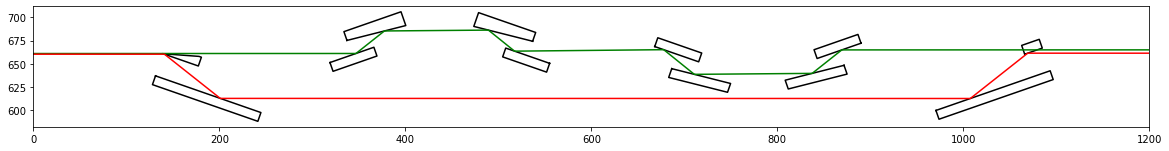

In [15]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for x in range(8):
    ax.plot([new_crystal[x].boundary[y][2]/1000 for y in [0, 1, 2, 3, 0]],
             [new_crystal[x].boundary[y][1]/1000 for y in [0, 1, 2, 3, 0]],
            'k')
    
for x in range(4):
    ax.plot([new_crystal_lower[x].boundary[y][2]/1000 for y in [0, 1, 2, 3, 0]],
             [new_crystal_lower[x].boundary[y][1]/1000 for y in [0, 1, 2, 3, 0]],
            'k')

ax.plot(new_path_upper[0][:,2]/1000,
        new_path_upper[0][:,1]/1000,'g')

ax.plot(new_path_lower[0][:,2]/1000,
        new_path_lower[0][:,1]/1000,'r')

ax.set_aspect("equal")
ax.set_xlim([0, 1200])

plt.show()

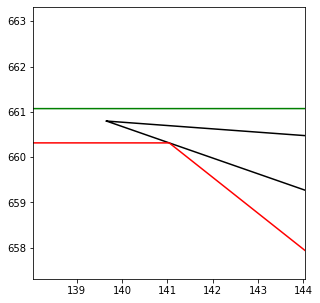

In [16]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

for x in range(8):
    ax.plot([new_crystal[x].boundary[y][2]/1000 for y in [0, 1, 2, 3, 0]],
             [new_crystal[x].boundary[y][1]/1000 for y in [0, 1, 2, 3, 0]],
            'k')
    
for x in range(4):
    ax.plot([new_crystal_lower[x].boundary[y][2]/1000 for y in [0, 1, 2, 3, 0]],
             [new_crystal_lower[x].boundary[y][1]/1000 for y in [0, 1, 2, 3, 0]],
            'k')

ax.plot(new_path_upper[0][:,2]/1000,
        new_path_upper[0][:,1]/1000,'g')

ax.plot(new_path_lower[0][:,2]/1000,
        new_path_lower[0][:,1]/1000,'r')

ax.set_aspect("equal")
ax.set_ylim([new_path_lower[0][2,1]/1000 - 3, new_path_lower[0][2,1]/1000 + 3])
ax.set_xlim([new_path_lower[0][2,2]/1000 - 3, new_path_lower[0][2,2]/1000 + 3])

plt.show()

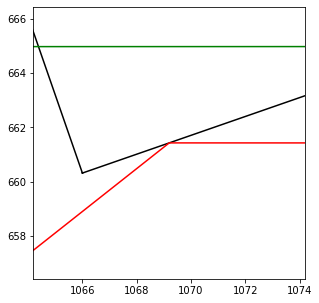

In [17]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

for x in range(8):
    ax.plot([new_crystal[x].boundary[y][2]/1000 for y in [0, 1, 2, 3, 0]],
             [new_crystal[x].boundary[y][1]/1000 for y in [0, 1, 2, 3, 0]],
            'k')
    
for x in range(4):
    ax.plot([new_crystal_lower[x].boundary[y][2]/1000 for y in [0, 1, 2, 3, 0]],
             [new_crystal_lower[x].boundary[y][1]/1000 for y in [0, 1, 2, 3, 0]],
            'k')

ax.plot(new_path_upper[0][:,2]/1000,
        new_path_upper[0][:,1]/1000,'g')

ax.plot(new_path_lower[0][:,2]/1000,
        new_path_lower[0][:,1]/1000,'r')

ax.set_aspect("equal")
ax.set_ylim([new_path_lower[0][-3,1]/1000 - 5, new_path_lower[0][-3,1]/1000 + 5])
ax.set_xlim([new_path_lower[0][-3,2]/1000 - 5, new_path_lower[0][-3,2]/1000 + 5])

plt.show()